## ILAS - Knowledge discovery & data mining
# Assignment 5

<span style="color:red;">Note: requires Python 3, numpy, scipy and pandas.</span>

## Task 1
### 1.
The Manhattan distance
$$ d(x,y) = \|x-y\|_1 = \sum_{i=1}^n \left|x_i - y_i \right| $$
for $x,y \in \mathbb{R}^n$ satisfies

1. Symmetry:
$\left|x_i - y_i\right| = \left|y_i-x_i\right|$ for all $1 \leq i \leq n$.

2. Positive definiteness:
The sum is always nonnegative, and
$$x = y \iff \left|x_i-y_i\right| = 0$$
for all $1\leq i \leq n$.

3. Triangle inequality:
$$\begin{align*}
d(x,y) &= \sum_{i=1}^n \left|x_i-y_i\right| \\
&= \sum_{i=1}^n \left|x_i-z_i+z_i-y_i\right| \\
&\leq \sum_{i=1}^n \left|x_i-z_i\right| + \left|z_i-y_i\right| \\
&= d(x,z) + d(z,y)
\end{align*}$$
by the triangle inequality for $|\cdot|$ in $\mathbb{R}$.

### 2.
$k$-means implementation.

In [1]:
import numpy as np
from collections.abc import Sequence
from functools import reduce

def k_means(D, k, d):
    '''Cluster data points in R^d using k-means.
    
    Parameters:
    D - List of numbers (int/float) or sequences (list/tuple) of numbers, representing data points in R^d.
    k - Number of clusters.
    d - Function object taking two points in R^d and returning their distance.
        Points must be represented by sequences of numbers.
    
    Returns:
    means - List of k points, the cluster means.
    cluster - List of k lists. C[i] contains the points in the i-th cluster.
    '''
    
    # We'd like to handle lists of numbers (i.e., points in R^1) without making the user have to pass in a list
    # of singleton sequences, but internal processing assumes points are sequences of numbers. Hence we preprocess.
    if not isinstance(D[0], Sequence):
        D = [(p,) for p in D]
        
    dim = len(D[0])  # Dimension of data space.
    N = len(D)  # Number of data points.
    means = [[0] * dim for i in range(k)]  # List of cluster means.
    
    # Place initial cluster means in the hypercuboid bounded by the extremal data points according to a uniform
    # distribution.
    for j in range(dim):
        min_val = min((D[i][j] for i in range(N)))
        max_val = max((D[i][j] for i in range(N)))
        for i in range(k):
            means[i][j] = np.random.uniform(min_val, max_val)
        
    # Quick and dirty function to calculate the mean of a bunch of points:
    plus = lambda x, y: [x[i]+y[i] for i in range(len(x))]
    average = lambda xs: tuple(x/len(xs) for x in reduce(plus, xs)) if xs else (0,)*dim  # Average of an empty set is 0.
    
    # Cluster the points.
    old_means = []
    while means != old_means:
        cluster = [[] for i in range(k)]
        for i in range(N):  # For each point,
            distances = [d(D[i],mu) for mu in means]  # calculate the distances to each cluster mean,
            cluster[distances.index(min(distances))].append(tuple(D[i]))  # and place the point in the cluster having the
                # closest mean (first come first served, if there is more than one mean with smallest distance.)
        old_means = means
        means = [average(cluster[i]) for i in range(k)]
        
    # Postprocess: convert singleton lists/tuples back to numbers.
    if dim == 1:
        means = [t[0] for t in means]
        cluster = [[t[0] for t in c] for c in cluster]
    
    return (means, cluster)

### 3.
We draw $\mu_i, 1\leq i\leq 3$ at random from $unif(-5,5)$, and $\sigma$ from $unif(0,2)$.

In [2]:
from scipy.spatial.distance import euclidean  # Euclidean metric

def manhattan(x, y):
    return sum(abs(x[i]-y[i]) for i in range(len(x)))

Do the experiment and plot some comparisons:


Standard deviation: 0.2431

		 m1 		 m2 		 m3
Actual 		 0.0564 	 1.0895 	 2.2303
Manhattan 	 0.0354 	 1.0989 	 2.2303
Euclidean 	 0.0354 	 1.0915 	 2.2215



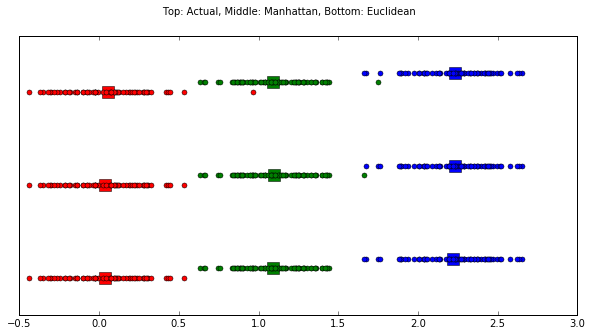

In [15]:
# Generate data points.
m1, m2, m3 = np.random.uniform(-5,5,3)
sd = np.random.uniform(0,2)

# Keep track of what points were generated from which seeds, for visualization later.
mu = tuple(sorted((m1, m2, m3)))
clusters = [[], [], []]
for i in range(200):
    j = np.random.randint(0,3)
    clusters[j].append(np.random.normal(mu[j], sd))

# Run k-means clustering.
data = [point for cluster in clusters for point in cluster]

# Get Manhattan means and clusters (and sort by increasing order of means, for vis).
manhattan_means, manhattan_clusters = k_means(data, 3, manhattan)
indices = np.argsort(manhattan_means)
manhattan_means = [manhattan_means[i] for i in indices]
manhattan_clusters = [manhattan_clusters[i] for i in indices]
# Do the same for the Euclidean metric.
euclidean_means, euclidean_clusters = k_means(data, 3, euclidean)
indices = np.argsort(euclidean_means)
euclidean_means = [euclidean_means[i] for i in indices]
euclidean_clusters = [euclidean_clusters[i] for i in indices]

# Output means.
print('\nStandard deviation: %0.4f' % sd)
print()
print('\t\t m1 \t\t m2 \t\t m3')
print('Actual \t\t %0.4f \t %0.4f \t %0.4f' % mu)
print('Manhattan \t %0.4f \t %0.4f \t %0.4f' % tuple(manhattan_means))
print('Euclidean \t %0.4f \t %0.4f \t %0.4f' % tuple(euclidean_means))
print()

# Visualize.
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(10,5))
axes = plt.gca()
axes.set_ylim([-2.3,0.7])
plt.tick_params(axis='y', which='both', left='off', right='off', labelleft='off')

plt.plot(mu[0], 0.1, 'rs', markersize=12)
plt.plot(clusters[0], [0.1]*len(clusters[0]), 'ro', markersize=5)
plt.plot(mu[1], 0.2, 'gs', markersize=12)
plt.plot(clusters[1], [0.2]*len(clusters[1]), 'go', markersize=5)
plt.plot(mu[2], 0.3, 'bs', markersize=12)
plt.plot(clusters[2], [0.3]*len(clusters[2]), 'bo', markersize=5)

plt.plot(manhattan_means[0], -0.9, 'rs', markersize=12)
plt.plot(manhattan_clusters[0], [-0.9]*len(manhattan_clusters[0]), 'ro', markersize=5)
plt.plot(manhattan_means[1], -0.8, 'gs', markersize=12)
plt.plot(manhattan_clusters[1], [-0.8]*len(manhattan_clusters[1]), 'go', markersize=5)
plt.plot(manhattan_means[2], -0.7, 'bs', markersize=12)
plt.plot(manhattan_clusters[2], [-0.7]*len(manhattan_clusters[2]), 'bo', markersize=5)

plt.plot(euclidean_means[0], -1.9, 'rs', markersize=12)
plt.plot(euclidean_clusters[0], [-1.9]*len(euclidean_clusters[0]), 'ro', markersize=5)
plt.plot(euclidean_means[1], -1.8, 'gs', markersize=12)
plt.plot(euclidean_clusters[1], [-1.8]*len(euclidean_clusters[1]), 'go', markersize=5)
plt.plot(euclidean_means[2], -1.7, 'bs', markersize=12)
plt.plot(euclidean_clusters[2], [-1.7]*len(euclidean_clusters[2]), 'bo', markersize=5)

plt.suptitle("Top: Actual, Middle: Manhattan, Bottom: Euclidean")
plt.show()

### 4, 5. Iris dataset.

In [4]:
import pandas
iris_raw_data = pandas.read_csv("iris.data", header=None)
iris_raw_data

,0,1,2,3,4
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
5,5.4,3.9,1.7,0.4,Iris-setosa
6,4.6,3.4,1.4,0.3,Iris-setosa
7,5.0,3.4,1.5,0.2,Iris-setosa
8,4.4,2.9,1.4,0.2,Iris-setosa
9,4.9,3.1,1.5,0.1,Iris-setosa


In [5]:
# Cluster data into k=3 clusters by first four attributes.
iris_data = iris_raw_data.ix[:, 0:3].values.tolist()
iris_manhattan_means, iris_manhattan_clusters = k_means(iris_data, 3, manhattan)
iris_euclidean_means, iris_euclidean_clusters = k_means(iris_data, 3, euclidean)

In [6]:
# Output means.
print('Manhattan:')
for t in iris_manhattan_means:
    print(t)
    
print('\nEuclidean:')
for t in iris_euclidean_means:
    print(t)

Manhattan:
(6.87027027027027, 3.0864864864864856, 5.745945945945945, 2.089189189189189)
(5.005999999999999, 3.4180000000000006, 1.464, 0.2439999999999999)
(5.904761904761906, 2.7460317460317465, 4.412698412698414, 1.4333333333333336)

Euclidean:
(6.8500000000000005, 3.073684210526315, 5.742105263157893, 2.0710526315789473)
(5.005999999999999, 3.4180000000000006, 1.464, 0.2439999999999999)
(5.901612903225807, 2.748387096774194, 4.393548387096775, 1.4338709677419357)


### 6.

Compute purity function.

In [7]:
def purity(clusters, groups):
    '''Compute purity function.
    
    Parameters:
    clusters - Indexable of sets, the clusters found by some clustering algorithm.
    groups - Grouping of the data based on some attribute.
    '''
    
    N = len([point for group in groups for point in group])  # Number of instances.
    return sum(max(len(cluster.intersection(group)) for group in groups) for cluster in clusters) / N

In [8]:
iris_manhattan_clusters

[[(6.9, 3.1, 4.9, 1.5),
  (6.7, 3.0, 5.0, 1.7),
  (6.3, 3.3, 6.0, 2.5),
  (7.1, 3.0, 5.9, 2.1),
  (6.3, 2.9, 5.6, 1.8),
  (6.5, 3.0, 5.8, 2.2),
  (7.6, 3.0, 6.6, 2.1),
  (7.3, 2.9, 6.3, 1.8),
  (6.7, 2.5, 5.8, 1.8),
  (7.2, 3.6, 6.1, 2.5),
  (6.5, 3.2, 5.1, 2.0),
  (6.4, 2.7, 5.3, 1.9),
  (6.8, 3.0, 5.5, 2.1),
  (6.4, 3.2, 5.3, 2.3),
  (6.5, 3.0, 5.5, 1.8),
  (7.7, 3.8, 6.7, 2.2),
  (7.7, 2.6, 6.9, 2.3),
  (6.9, 3.2, 5.7, 2.3),
  (7.7, 2.8, 6.7, 2.0),
  (6.7, 3.3, 5.7, 2.1),
  (7.2, 3.2, 6.0, 1.8),
  (6.4, 2.8, 5.6, 2.1),
  (7.2, 3.0, 5.8, 1.6),
  (7.4, 2.8, 6.1, 1.9),
  (7.9, 3.8, 6.4, 2.0),
  (6.4, 2.8, 5.6, 2.2),
  (7.7, 3.0, 6.1, 2.3),
  (6.3, 3.4, 5.6, 2.4),
  (6.4, 3.1, 5.5, 1.8),
  (6.9, 3.1, 5.4, 2.1),
  (6.7, 3.1, 5.6, 2.4),
  (6.9, 3.1, 5.1, 2.3),
  (6.8, 3.2, 5.9, 2.3),
  (6.7, 3.3, 5.7, 2.5),
  (6.7, 3.0, 5.2, 2.3),
  (6.5, 3.0, 5.2, 2.0),
  (6.2, 3.4, 5.4, 2.3)],
 [(5.1, 3.5, 1.4, 0.2),
  (4.9, 3.0, 1.4, 0.2),
  (4.7, 3.2, 1.3, 0.2),
  (4.6, 3.1, 1.5, 0.2),
  (5.0, 3.6, 1.

In [9]:
# Split data according to species.
# Convert to sets so we can use built-in functions to compute the intersection with...
K1 = set(tuple(t) for t in iris_raw_data[iris_raw_data[4] == 'Iris-setosa'].ix[:, 0:3].values.tolist())
K2 = set(tuple(t) for t in iris_raw_data[iris_raw_data[4] == 'Iris-versicolor'].ix[:, 0:3].values.tolist())
K3 = set(tuple(t) for t in iris_raw_data[iris_raw_data[4] == 'Iris-virginica'].ix[:, 0:3].values.tolist())
# ... the clusters found.
# Manhattan:
C1_man = set(iris_manhattan_clusters[0])
C2_man = set(iris_manhattan_clusters[1])
C3_man = set(iris_manhattan_clusters[2])
# Euclidean.
C1_euc = set(iris_euclidean_clusters[0])
C2_euc = set(iris_euclidean_clusters[1])
C3_euc = set(iris_euclidean_clusters[2])

In [10]:
# Manhattan clusters
purity((C1_man,C2_man,C3_man),(K1,K2,K3))

0.891156462585034

In [11]:
# Euclidean clusters
purity((C1_euc,C2_euc,C3_euc),(K1,K2,K3))

0.8979591836734694